## 도구 선택(병렬/연쇄/조건) 자체를 LLM function-calling으로 “자동화

In [1]:
from dotenv import load_dotenv
import os
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

# 환경변수 로드
load_dotenv()

# API 키 불러오기
openai_api_key = os.environ["OPENAI_API_KEY"]
pinecone_api_key = os.environ["PINECONE_API_KEY"]


In [ ]:
import asyncio
import re, json, os
from typing import Annotated, List, Any, Dict
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_mcp_adapters.client import MultiServerMCPClient
from operator import add

# 1. Chatbot State 정의
class ChatbotState(TypedDict):
    question: str
    tools: Annotated[List[str], add]  
    case_number: str
    full_name: str
    neo4j_documents: Any
    vector_documents: Any
    final_answer: str
    messages: Annotated[List, add_messages]
    pending_vector: bool
    mode: str
    decision_reasoning: str
    send_to_slack: bool
    slack_recipient: str


memory = MemorySaver()
model = ChatOpenAI(model="gpt-4o", temperature=0.1)

# MCP Multi-Tool Client
client = MultiServerMCPClient(
    {
        "local_patient_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/mcp_local_patient_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mco_vectordb_server.py"],
            "transport": "stdio",
        },
    }
)

tools = await client.get_tools()

tools_dict = {tool.name: tool for tool in tools}

print(tools_dict)

{'local_patient_retriever': StructuredTool(name='local_patient_retriever', description='\n    환자 케이스 번호(case) 혹은 full_name 으로 로컬 JSON 데이터에서 검색\n    ', args_schema={'properties': {'case_number': {'default': '', 'title': 'Case Number', 'type': 'string'}, 'full_name': {'default': '', 'title': 'Full Name', 'type': 'string'}}, 'title': 'local_patient_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7353a033e290>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x73536c87e830>)}


In [3]:
# 2. 도구 선택 함수 스키마
tool_selector_function = {
    "name": "select_tools",
    "description": """질문 분석 후 필요한 도구와 실행 방식을 결정합니다.
    - 환자 정보만: local_patient_retriever
    - 의학 지식만: VectorDB_retriever  
    - 둘 다 병렬: 독립적인 정보가 모두 필요
    - 둘 다 연쇄: 환자 정보 기반으로 의학 지식 추가 조회""",
    "parameters": {
        "type": "object",
        "properties": {
            "tools": {
                "type": "array",
                "items": {"type": "string"},
                "description": "사용할 도구 목록"
            },
            "mode": {
                "type": "string",
                "enum": ["single", "parallel", "sequential"],
                "description": "실행 방식"
            },
            "pending_vector": {
                "type": "boolean",
                "description": "환자 정보 조회 후 벡터DB 연쇄 호출 필요 여부"
            },
            "reasoning": {
                "type": "string",
                "description": "결정 이유"
            }
        },
        "required": ["tools", "mode", "pending_vector"]
    }
}


In [28]:
# 3. 시스템 프롬프트
tool_select_prompt = """
의료 QA 챗봇의 도구 선택을 담당합니다.
질문을 분석하여 적절한 도구와 실행 방식을 결정하세요.

질문에 **의학 지식(예: 주의사항, 부작용, 가이드라인)** 이 필요하면 반드시 VectorDB_retriever를 포함해야 합니다.
 
도구 설명:
- local_patient_retriever: 환자 케이스 정보 (이름, case번호, 진단, 수술 등)
- VectorDB_retriever: 일반 의학 지식 (질병, 치료법, 약물, 가이드라인 등)

실행 방식:
- single: 하나의 도구만 사용
- parallel: 두 도구를 병렬로 독립 실행
- sequential: 환자 정보 조회 후 해당 정보로 의학 지식 추가 조회

예시:
- "최도윤 환자 진단명?" → local_patient_retriever, single
- "폐렴 치료법?" → VectorDB_retriever, single  
- "최도윤 환자 진단과 폐렴 치료법" → 둘 다, parallel
- "최도윤 환자의 수술과 해당 수술 주의사항" → 둘 다, sequential
"""

LLM_SYSTEM_PROMPT = """
당신은 의료 데이터에 특화된 전문가 AI입니다. 사용자의 질문에 대해 제공된 정보를 바탕으로 정확하고 유용한 답변을 제공하세요.

# Local Patient Data
{LocalPatient}

# Vector DB Data  
{VectorDB}

# Question
{question}
"""

In [4]:
tool_select_prompt = """
너는 의료 문서 검색과 환자 정보 조회를 기반으로 정보를 제공하는 의료 도우미야.

다음 기준을 참고해서 적절한 도구를 선택해:
- 환자 이름이나 케이스 번호가 질문에 포함되어 있다면, 'local_patient_retriever'를 사용해.
- 진단명, 수술명, 마취제 등 의학 지식을 기반으로 논문 검색이 필요할 경우 'VectorDB_retriever'를 사용해.
- 둘 다 필요한 경우, 모드는 다음과 같이 선택해:
    - 순차적으로 먼저 환자 정보를 조회하고 이를 기반으로 문서를 검색하려면 'sequential'
    - 두 작업을 동시에 처리해도 되는 경우라면 'parallel'
- 단일 도구만 필요한 경우에는 'single' 모드를 사용해.

'tools', 'mode', 'pending_vector', 'reasoning' 값을 포함한 JSON 객체 형태로 select_tools 함수를 호출해.
"""

LLM_SYSTEM_PROMPT = """
당신은 의료 데이터에 특화된 전문가 AI입니다. 사용자의 질문에 대해 제공된 정보를 바탕으로 정확하고 유용한 답변을 제공하세요.

# Local Patient Data
{LocalPatient}

# Vector DB Data  
{VectorDB}

# Question
{question}
"""

In [5]:
# 4. 노드 함수들

async def decision_tools(state: ChatbotState) -> ChatbotState:
    """LLM Function Calling으로 도구 선택"""
    q = state['question']
    
    response = await model.ainvoke([
        {"role": "system", "content": tool_select_prompt},
        {"role": "user", "content": q}
    ], functions=[tool_selector_function], function_call="auto")
    
    fc = getattr(response, 'function_call', None)
    if fc and fc.name == 'select_tools':
        args = json.loads(fc.arguments)
    else:
        # 기본값
        args = {
            'tools': ['local_patient_retriever'], 
            'mode': 'single',
            'pending_vector': False, 
            'reasoning': 'fallback to patient search'
        }
    
    return {
        **state,
        'tools': args['tools'],
        'mode': args['mode'],
        'pending_vector': args['pending_vector'],
        'decision_reasoning': args.get('reasoning', '')
    }

async def slack_decider(state: ChatbotState) -> ChatbotState:
    """Slack 전송 필요성 판단"""
    q = state["question"]
    send_flag = bool(re.search(r"(.+?)\s*(의사|선생님|간호사|님)\s*에게\s*(보내줘|전송해줘|알려줘)", q))
    
    recipient = ""
    if send_flag:
        match = re.search(r"(.+?)\s*(의사|선생님|간호사|님)\s*에게", q)
        if match:
            recipient = match.group(1)
    
    return {
        **state, 
        "send_to_slack": send_flag,
        "slack_recipient": recipient
    }

async def extract_id(state: ChatbotState) -> ChatbotState:
    """환자 ID 추출"""
    q = state["question"]
    
    # Case 번호 추출
    case_match = re.search(r"(APM-\d{2}-\d+)", q)
    case_number = case_match.group(1) if case_match else ""
    
    # 환자명 추출  
    name_match = re.search(r"([가-힣]{2,4})\s*환자", q)
    full_name = name_match.group(1) if name_match else ""
    
    return {**state, "case_number": case_number, "full_name": full_name}

async def local_patient_db(state: ChatbotState) -> ChatbotState:
    """환자 DB 조회"""
    tool = tools_dict.get("local_patient_retriever")
    
    params = {
        "case_number": state.get("case_number", ""),
        "full_name": state.get("full_name", "")
    }
    
    # 둘 다 없으면 질문 전체를 사용
    if not params["case_number"] and not params["full_name"]:
        params["full_name"] = state["question"]
    
    result = await tool.ainvoke(params)
    return {**state, "neo4j_documents": result}

# [5] extract_patient_info: 벡터DB 쿼리용 질병/수술 등 추출 (연쇄구조용)
def extract_patient_info(state: ChatbotState) -> ChatbotState:
    # 실제 구현시 LLM/정규식 등으로 원하는 필드 추출
    patient = state.get("neo4j_documents")
    agent = None
    if isinstance(patient, dict):
        agent = patient.get("agent")
    elif isinstance(patient, str):
        # JSON일 수도 있음
        try:
            d = json.loads(patient)
            agent = d.get("agent")
        except:
            agent = None
    info = f"마취제: {agent}" if agent else ""
    return {**state, "patient_info": info}
    
async def vector_db(state: ChatbotState) -> ChatbotState:
    """벡터 DB 조회"""
    tool = tools_dict.get("VectorDB_retriever")
    
    # sequential 모드면 환자 정보 기반 쿼리 생성
    if state.get("pending_vector") and state.get("neo4j_documents"):
        patient_data = state["neo4j_documents"]
        if isinstance(patient_data, dict):
            # 환자 정보에서 키워드 추출하여 쿼리 생성
            diagnosis = patient_data.get("diagnosis", "")
            surgery = patient_data.get("surgery", "")
            agent = patient_data.get("agent", "")
            
            query_parts = []
            if diagnosis:
                query_parts.append(f"{diagnosis}")
            if surgery:
                query_parts.append(f"{surgery}")
            if agent:
                query_parts.append(f"{agent}")
                
            if query_parts:
                query = f"{' '.join(query_parts)} 관련 의학정보, 주의사항, 부작용을 알려주세요. 원래 질문: {state['question']}"
            else:
                query = state["question"]
        else:
            query = state["question"]
    else:
        query = state["question"]
    
    result = await tool.ainvoke({"query": query})
    return {**state, "vector_documents": result}

async def merge_outputs(state: ChatbotState) -> ChatbotState:
    """최종 답변 생성"""
    sys_content = LLM_SYSTEM_PROMPT.format(
        LocalPatient=state.get("neo4j_documents", "None"),
        VectorDB=state.get("vector_documents", "None"),
        question=state.get("question")
    )
    
    resp = await model.ainvoke([
        {"role": "system", "content": sys_content},
        {"role": "user", "content": state["question"]}
    ])
    
    text = resp.content if isinstance(resp, AIMessage) else str(resp)
    
    return {
        **state,
        "final_answer": text,
        "messages": [("user", state["question"]), ("assistant", text)]
    }

async def slack_node(state: ChatbotState) -> ChatbotState:
    """Slack 전송 (실제 구현 필요)"""
    if state.get("send_to_slack"):
        recipient = state.get("slack_recipient", "알 수 없는 수신자")
        print(f"[SLACK] {recipient}에게 메시지 전송: {state['final_answer'][:100]}...")
        # 실제 Slack API 호출 구현 필요
    
    return state

In [6]:
# --- 라우팅 함수 ---
def route_after_decision(state: ChatbotState):
    tools = state["tools"]
    mode  = state["mode"]
    # 1) 둘 다 필요
    if "local_patient_retriever" in tools and "VectorDB_retriever" in tools:
        if mode == "parallel":
            return ["local_patient_retriever", "VectorDB_retriever"]
        else:  # single 도 아니고 parallel 도 아니면 sequential
            return "local_patient_retriever"
    # 2) 로컬만
    if "local_patient_retriever" in tools:
        return "local_patient_retriever"
    # 3) 벡터만
    if "VectorDB_retriever" in tools:
        return "VectorDB_retriever"
    # 기본
    return "local_patient_retriever"
    
def route_after_local(state: ChatbotState):
    if state.get("pending_vector"):
        return "pending_vector"  # 이 값이 mapping dict에 존재해야 함
    return "no_vector"



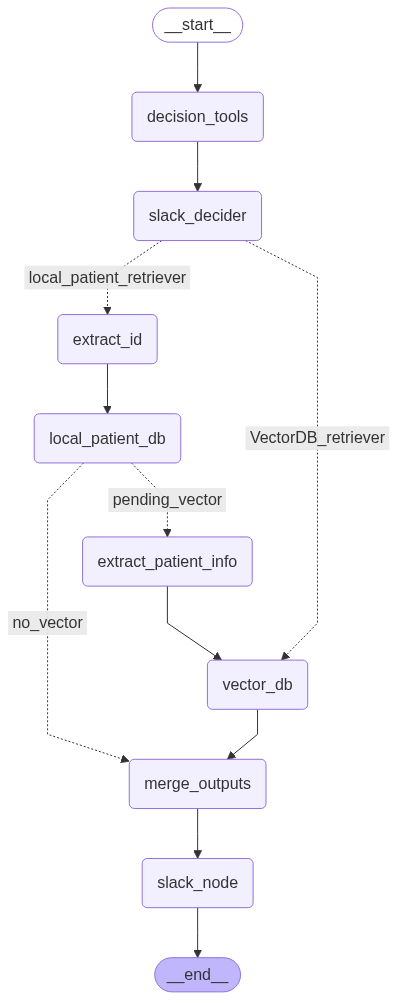

In [7]:
# --- graph builder --------------------

builder = StateGraph(ChatbotState)

# 1) Add every node
builder.add_node("decision_tools",      decision_tools)
builder.add_node("slack_decider",       slack_decider)
builder.add_node("extract_id",          extract_id)
builder.add_node("local_patient_db",    local_patient_db)
builder.add_node("extract_patient_info",extract_patient_info)
builder.add_node("vector_db",           vector_db)
builder.add_node("merge_outputs",       merge_outputs)
builder.add_node("slack_node",          slack_node)

# 2) Start → decision_tools → slack_decider
builder.add_edge(START,            "decision_tools")
builder.add_edge("decision_tools", "slack_decider")

# 3) slack_decider → extract_id and/or vector_db
builder.add_conditional_edges(
    "slack_decider",
    route_after_decision,
    {
        # route_after_decision이 반환하는 값(도구 이름)을 → 다음 노드로 매핑
        "local_patient_retriever":   "extract_id",
        "VectorDB_retriever":        "vector_db",
    }
)

# 4) extract_id → local_patient_db
builder.add_edge("extract_id", "local_patient_db")

# 5) local_patient_db → pending_vector=True 이면 extract_patient_info, 아니면 merge_outputs
builder.add_conditional_edges(
    "local_patient_db",
    route_after_local,  # pending_vector 여부 보고
    {
        "pending_vector":    "extract_patient_info",
        "no_vector":         "merge_outputs",
    }
)

# extract_patient_info → vector_db → merge_outputs
builder.add_edge("extract_patient_info", "vector_db")
builder.add_edge("vector_db",           "merge_outputs")
builder.add_edge("merge_outputs", "slack_node")
builder.add_edge("slack_node",    END)

graph = builder.compile(checkpointer=memory)
graph

In [8]:
# 7. 실행 함수
async def run_chatbot(question: str, thread_id: str = "1"):
    """챗봇 실행"""
    config = {"configurable": {"thread_id": thread_id}}
    
    initial_state = {
        "question": question,
        "tools": [],
        "case_number": "",
        "full_name": "",
        "neo4j_documents": None,
        "vector_documents": None,
        "final_answer": "",
        "messages": [],
        "pending_vector": False,
        "mode": "single",
        "decision_reasoning": "",
        "send_to_slack": False,
        "slack_recipient": ""
    }
    
    async for event in graph.astream(initial_state, config=config):
        if "merge_outputs" in event:
            result = event["merge_outputs"]
            print("=== 최종 결과 ===")
            print(f"질문: {result['question']}")
            print(f"사용된 도구: {result['tools']}")
            print(f"실행 방식: {result['mode']}")
            print(f"결정 이유: {result['decision_reasoning']}")
            print(f"\n환자 데이터: {result['neo4j_documents']}")
            print(f"\n벡터 DB 데이터: {result['vector_documents']}")
            print(f"\n답변: {result['final_answer']}")
            
            if result['send_to_slack']:
                print(f"\n[SLACK] {result['slack_recipient']}에게 전송됨")

In [9]:
# 8. 테스트 실행
await run_chatbot("11세 남아 최도윤 환자의 수술명과 기관삽관 시 주의할 점을 알려줘.")

=== 최종 결과 ===
질문: 11세 남아 최도윤 환자의 수술명과 기관삽관 시 주의할 점을 알려줘.
사용된 도구: ['local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever']
실행 방식: single
결정 이유: fallback to patient search

환자 데이터: {
  "case": "APM-12-243",
  "full_name": "최도윤",
  "age": "11세 남아",
  "diagnosis": "거대방광요관역류",
  "surgery": "요관 재건술",
  "anesthesia": "전신마취",
  "agent": [
    "Sevoflurane"
  ],
  "notes": "과거 마취력 있음, 항생제 전처치 포함"
}

벡터 DB 데이터: None

답변: 최도윤 환자의 수술명은 "요관 재건술"입니다. 이 수술은 거대방광요관역류를 치료하기 위한 절차입니다.

기관삽관 시 주의할 점은 다음과 같습니다:

1. **전신마취**: 최도윤 환자는 전신마취를 받으며, 마취제는 Sevoflurane이 사용됩니다. Sevoflurane은 비교적 안전한 흡입 마취제로, 소아에서 자주 사용됩니다.

2. **과거 마취력**: 환자는 과거에 마취를 받은 경험이 있으므로, 이전 마취 시의 반응이나 합병증이 있었는지 확인하는 것이 중요합니다.

3. **항생제 전처치**: 수술 전 항생제 전처치가 포함되어 있으므로, 항생제에 대한 알레르기 반응이 없는지 확인해야 합니다.

4. **소아 환자 특성**: 소아는 성인과 다른 해부학적, 생리학적 특성을 가지고 있으므로, 기관삽관 시 적절한 크기의 기관튜브를 선택하고, 삽관 과정에

In [10]:
await run_chatbot("분유를 먹은 아이는 몇 시간 후 전신마취를 안전하게 받을 수 있는가?")

=== 최종 결과 ===
질문: 분유를 먹은 아이는 몇 시간 후 전신마취를 안전하게 받을 수 있는가?
사용된 도구: ['local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_r

In [15]:
await run_chatbot("11세 남아 최도윤 환자의 수술에 사용된 마취제의 소아용 권장 용량과 부작용을 알려줘.")

=== 최종 결과 ===
질문: 11세 남아 최도윤 환자의 수술에 사용된 마취제의 소아용 권장 용량과 부작용을 알려줘.
사용된 도구: ['local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local_patient_retriever', 'local

In [61]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

# query test
#question = "환자번호 APM-12-243의 최근 진단명과 예정된 수술을 알려줘. 그리고 해당 수술 시 적절한 수액 주입 속도는 어느 정도가 좋을까?"
# question = "중이염 환자가 받는 수술과 관련 부작용, 마취제 알려줘."
question = "페닐케톤뇨증 치료법과 부작용 알려줘."

initial_state = {
    "question": question,
    "tools": [],
    "case_number": "",
    "full_name": "",
    "neo4j_documents": None,
    "vector_documents": None,
    "final_answer": "",
    "messages": [],
    "pending_vector": False,
    "mode": None,
    "decision_reasoning": ""
}

events = []
async for event in graph.astream(initial_state, config=config):
    if "merge_outputs" in event:
        out = event["merge_outputs"]
        print("질문:", out["question"])
        print("LocalPatient context:", out["neo4j_documents"])
        print("VectorDB context:", out["vector_documents"])
        print("답변:", out["final_answer"])
        print("결정 이유:", out.get("decision_reasoning"))


질문: 페닐케톤뇨증 치료법과 부작용 알려줘.
LocalPatient context: {
  "error": "No patient found for case_number='' full_name='페닐케톤뇨증 치료법과 부작용 알려줘.'"
}
VectorDB context: None
답변: 페닐케톤뇨증(PKU)의 주요 치료법은 페닐알라닌이 적은 식단을 유지하는 것입니다. 이는 고단백 식품(육류, 생선, 계란, 유제품 등)과 일부 곡물 및 인공 감미료를 피하는 것을 포함합니다. 대신, 페닐알라닌이 제거된 특수 조제식품과 보충제를 섭취하여 필요한 영양소를 공급받습니다.

치료의 부작용은 주로 식단 제한으로 인한 영양 불균형이 있을 수 있으며, 이는 성장과 발달에 영향을 미칠 수 있습니다. 따라서 정기적인 혈액 검사와 영양 상담을 통해 적절한 영양 상태를 유지하는 것이 중요합니다.
결정 이유: fallback


InvalidUpdateError: At key 'question': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

## sequential

In [ ]:
from typing import Annotated, List, TypedDict, Dict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import json
import re
from langgraph.prebuilt import create_react_agent
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

load_dotenv()

# langgraph state 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "사용자 원본 질문"]
    flow_type: Annotated[str, "데이터베이스 조회 흐름 (sequential, parallel, neo4j_only, vector_db_only)"]
    patient_info: Annotated[str, "순차 처리를 위해 Neo4j에서 추출한 환자 정보"]
    decision_slack: Annotated[str, "슬랙 전송 여부 결정"]

    # 기존 필드
    tools: Annotated[List, "Tools"]
    tools_query: Annotated[List, "Tools_Query"]
    neo4j_documents: Annotated[List, "Neo4j_Documents"]
    vector_documents : Annotated[List,"Vector_Documents"]
    final_answer: Annotated[str, "Final_Answer"]
    slack_response: Annotated[str, "Slack_Response"]
    messages: Annotated[List, add_messages]

memory = MemorySaver()


model_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
model = ChatOpenAI(temperature=0.2,
                    model_name="gpt-4o")
# tokenizer = AutoTokenizer.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model = AutoModelForCausalLM.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model.to(device)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x76fc27b96350>>
Traceback (most recent call last):
  File "/home/hyewon/boaz/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# tools_router_function.py
tool_router_schema = {
    "name": "route_question",
    "description": "사용자 질문의 의도를 파악하여 가장 적절한 데이터 조회 경로를 결정합니다.",
    "parameters": {
        "type": "object",
        "properties": {
            "flow_type": {
                "type": "string",
                "enum": ["sequential", "parallel", "neo4j_only", "vector_db_only"],
                "description": """질문에 가장 적합한 데이터 처리 흐름:
- 'sequential': 환자 정보를 먼저 조회하고, 그 결과를 바탕으로 추가적인 의학 정보 검색이 필요할 때. (예: "OOO 환자의 수술에 사용할 마취제의 부작용 알려줘")
- 'parallel': 환자 정보와 일반 의학 정보가 독립적으로 모두 필요할 때. (예: "OOO 환자의 진단명 알려주고, 폐렴의 일반적인 치료법도 알려줘")
- 'neo4j_only': 환자 정보만 필요할 때. (예: "OOO 환자 나이가 어떻게 돼?")
- 'vector_db_only': 일반 의학 정보만 필요할 때. (예: "전신마취란 무엇인가?")
"""
            },
            "neo4j_query": {
                "type": "string",
                "description": "Neo4j 환자 DB에서 정보를 조회하기 위한 자연어 쿼리입니다. flow_type이 'neo4j_only', 'parallel', 'sequential'일 경우에만 생성됩니다."
            },
            "vector_db_query": {
                "type": "string",
                "description": "Vector DB에서 의학 정보를 검색하기 위한 자연어 쿼리입니다. flow_type이 'vector_db_only' 또는 'parallel'일 경우에만 생성됩니다. 'sequential' 흐름에서는 이 필드를 사용하지 않습니다."
            }
        },
        "required": ["flow_type"]
    }
}

## base

In [ ]:
from typing import Annotated, List, TypedDict, Dict
from langgraph.graph.message import add_messages
from langchain_community.document_transformers import LongContextReorder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForCausalLM
import os

load_dotenv()
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 사용 모델들
from dotenv import load_dotenv
import os
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

model_client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
model = ChatOpenAI(temperature=0.2,
                    model_name="gpt-4o")
# tokenizer = AutoTokenizer.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model = AutoModelForCausalLM.from_pretrained("DeepRetrieval/DeepRetrieval-PubMed-3B", trust_remote_code=True)
# deepretrieval_model.to(device)


In [ ]:
# langgraph state 정의
class ChatbotState(TypedDict):
    question: Annotated[str, "Question"]  
    decision_slack: Annotated[str, "Decision_slack"]
    tools: Annotated[List, "Tools"]
    tools_query: Annotated[List, "Tools_Query"]
    # regenerated_question: Annotated[str, "Regenerated Question"]
    neo4j_documents: Annotated[List, "Neo4j_Documents"]  
    vector_documents : Annotated[List,"Vector_Documents"]
    final_answer: Annotated[str, "Final_Answer"]  
    slack_response: Annotated[str, "Slack_Response"]
    messages: Annotated[List, add_messages] 

memory = MemorySaver()

# MCP 서버들 불러오기
mcp_client = MultiServerMCPClient(
    {
        "neo4j_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mcp_vectordb_server.py"],
            "transport": "stdio",
        },
        # Slack MCP 서버 설정
        "slack": {
            "command": "npx",
            "args": [
                "-y",
                "@modelcontextprotocol/server-slack"
            ],
            "transport": "stdio", 
            "env": {
                "SLACK_BOT_TOKEN": os.getenv("SLACK_BOT_TOKEN"),
                "SLACK_TEAM_ID": os.getenv("SLACK_TEAM_ID"),
                # 선택사항: 특정 채널만 접근하려는 경우
                # "SLACK_CHANNEL_IDS": 
            }
        }
    }
)

# MCP 서버 잘 가져왔는지 확인
mcp_tools = await mcp_client.get_tools()
tools_dict = {tool.name: tool for tool in mcp_tools}
print(tools_dict)

{'neo4j_retriever': StructuredTool(name='neo4j_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'neo4j_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x77308425dbd0>), 'VectorDB_retriever': StructuredTool(name='VectorDB_retriever', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'VectorDB_retrieverArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x77308421a320>), 'slack_list_channels': StructuredTool(name='slack_list_channels', description='List public or pre-defined channels in the workspace with pagination', args_schema={'type': 'object', 'properties': {'limit': {'type': 'number', 'description': 'Maximum number of channels to return (default 100, max

In [ ]:
function_calling_tools = [
    {
        "type": "function",
        "name": "neo4j_retriever",
        "description": """Use this tool when the user's query is explicitly about patient-specific 
            clinical information or refers to structured medical records.

            This includes queries containing terms such as: 
            '환자', '환자정보', '환자기록', '환자이력', '환자데이터', '환자상태', 
            '수술이력', '검사기록', '진료기록', '입원', '퇴원', '복용약물',
            '진단', '수술명', '마취제', '마취제 유형', '수술 전 상태', '수술 후 상태'.

            These queries typically require retrieving structured data from graph-based 
            medical records (e.g., Neo4j) related to an individual patient or to specific 
            clinical procedures.

            This tool is designed to access and return relevant information such as:
            surgery history, diagnoses, anesthesia types used, pre- and post-operative conditions, 
            medication usage, lab results, and hospitalization records.

            Use this tool when the question involves:
            - Specific patients
            - Specific treatments or surgeries
            - Named diagnoses or procedures
            - Clinical state before/after operations

            Do not use this tool for general medical knowledge, non-clinical topics, or 
            queries unrelated to structured or relational patient data.""",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": """Please write the query as a natural language question about the patient's clinical records.

                    The query will be interpreted to explore nodes (e.g., Surgery, Anesthesia, Diagnosis, Patient) and their relationships (e.g., surgeries received by a specific patient) in a graph database.

                    For example, the question "Tell me the name of the most recent surgery and the anesthesia used" will be processed as a query exploring connections between Surgery and Anesthesia nodes.

                    Also, the question "Tell me the pre-operative condition and diagnosis of patient Hong Gil-dong" will be interpreted as a query that finds the Person node with the name 'Hong Gil-dong' and extracts the related Pre-op condition and Diagnosis nodes.

                    If a patient name is specified, please write the query to retrieve not only that patient but also other patients with similar symptoms.

                    If no patient name is given, please write the query to search for patients matching the symptoms, surgery names, or diagnoses mentioned in the question.

                    The more specific the patient information or clinical conditions included, the more accurately the relevant data can be retrieved."""
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    },
    {
        "type": "function",
        "name": "VectorDB_retriever",
        "description": """BrokenPipeErrorUse this tool when the user's query involves general clinical or medical knowledge that is not tied to a specific patient.

                This includes queries containing medical or procedural terms such as:
                surgery names (e.g., "cholecystectomy", "cardiac surgery"), anesthesia types (e.g., "general anesthesia", "local anesthesia"), medications, clinical processes, or treatment guidelines.

                Example queries:
                - "How does general anesthesia work?"
                - "What are common complications of this surgery?"
                - "What anesthetics are typically used in pediatric patients?"

                These types of queries are interpreted as requests for background medical knowledge or conceptual explanations. The tool retrieves semantically relevant information from a vector-based medical knowledge database.

                Do not use this tool for patient-specific record queries or when structured relational data is needed, such as diagnosis timelines or surgical histories.""",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": """Construct a query that focuses on general medical or clinical knowledge, excluding any patient-specific details.

                The query should be based on concepts extracted from the user's original question, such as surgery names, anesthesia types, diagnoses, medications, or treatment processes.

                For example, if the user asks "What kind of anesthesia was used for Kim's surgery?", the query should be reformulated as "What types of anesthesia are commonly used for that kind of surgery?"

                Avoid including patient names, identifiers, or individual medical histories. Focus on retrieving background information or typical medical explanations that are generally applicable."""
                }
            },
            "required": ["query"],
            "additionalProperties": False
        }
    }
]

In [ ]:
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
사용자의 질문에 대해 다음 두 가지 출처의 정보를 참고하여 답변을 생성하세요:

1. 🔎 Neo4j 검색 결과: 구조화된 환자 관련 정보 (예: 수술 이력, 검사 기록 등)
2. 📚 VectorDB 검색 결과: 일반적인 의학 지식 (예: 증상 설명, 치료 가이드라인 등)

- 두 결과 모두 존재할 경우, 각 출처를 구분하여 통합적으로 반영하되, 중복 내용은 요약하거나 통합하세요.
- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하되, 정보의 한계에 대해 언급하지 말고 최대한 성실히 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# Neo4j CONTEXT
{Neo4j}

# Vector DB CONTEXT
{VectorDB}

# Question
{question}
"""


# LLM_REGENERATED_QUESTION = """
# You are a helpful assistant specialized in pediatric anesthesia. 
# You first think about the reasoning process in your mind and then rewrite the user’s question into a more effective form for document retrieval. 
# Your task is to convert user questions into concise, keyword-based queries suitable for sparse vector-based search in a pediatric anesthesia knowledge base.

# Show your thought process in <think> </think> tags.  
# Your final response must be in JSON format within <answer> </answer> tags.  
# For example:  
# <answer>  
# {{  
#   "query": "..."  
# }}  
# </answer>

# Note: You may use Boolean operators (AND, OR) and parentheses when needed to group terms.

# Here’s the user’s question related to pediatric anesthesia:  
# {question}

# Assistant: Let me think step by step.  
# <think>
# """

LLM_DECISION_SLACK = """
You are a decision-making assistant for Slack dispatch.
If the user asks to send a message or question to a specific person via Slack (e.g., '~에게 보내줘', '~에게 전송해줘'),
respond with "Yes".
Otherwise, respond with "No".

Only respond with "Yes" or "No". Do not include any explanation or formatting.
"""

In [ ]:
import json
import re
from langgraph.prebuilt import create_react_agent

SEND_COMMANDS = ["보내줘", "전송해줘", "전달해줘"]

# def determine_slack_usage(query: str) -> str:
#     command_pattern = "|".join(SEND_COMMANDS)  
#     pattern = re.compile(rf"(.+?)에게\s*(.+?)\s*(?:Slack으로\s*)?({command_pattern})")
#     m = pattern.search(query)
#     return 'Yes' if m else 'No'

def determine_slack_usage(query: str) -> str:
    return 'Yes' if any(cmd in query for cmd in SEND_COMMANDS) else 'No'

async def decision_slack(state: ChatbotState):
    user_query = state["question"]

    # 1) Rule-based 판단
    use_slack = determine_slack_usage(user_query)
    response = use_slack  # 기본값 설정

    # 2) 패턴은 일부 있지만 명확하지 않은 경우 → LLM 판단
    if use_slack.lower() == 'no' and ("에게" in user_query or any(cmd in user_query for cmd in SEND_COMMANDS)):
        llm_response = await model.ainvoke(f"{LLM_DECISION_SLACK}\n\n{user_query}")
        response = llm_response

    return ChatbotState(decision_slack=response)

async def decision_tools(state: ChatbotState):
    
    question = state["question"]

    input_messages = [
        {"role": "system", "content": "Decide which tools to use to answer the user's question. You may call one or both."},
        {"role": "user", "content": question}
    ]
    
    response = model_client.responses.create(model="gpt-4.1",
                                             input=input_messages,
                                             tools=function_calling_tools)
    
    tools_name = [tool.name for tool in response.output]
    tools_query = [json.loads(call.arguments)["query"] for call in response.output]

    return ChatbotState(tools=tools_name,
                        tools_query=tools_query)

async def vector_db(state: ChatbotState):
    question = None
    for tool, q in zip(state["tools"], state["tools_query"]):
        if tool == "VectorDB_retriever":
            question = q
            break

    # 질문 재생성
    # input_text = LLM_REGENERATED_QUESTION.format(question = question)
    # inputs = tokenizer(input_text, return_tensors="pt")
    # outputs = model.generate(**inputs, 
    #                          max_new_tokens=500,
    #                          temperature = 0.6)
    # response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
    vectordb_tool = tools_dict["VectorDB_retriever"]
        
    result = await vectordb_tool.ainvoke({"query": question})

    return ChatbotState(vector_documents=result,
                        # regenerated_question=response
                        )

async def neo4j_db(state: ChatbotState):
    question = None
    for tool, q in zip(state["tools"], state["tools_query"]):
        if tool == "neo4j_retriever":
            question = q
            break
    
    neo4j_tool = tools_dict.get("neo4j_retriever")
    
    result = await neo4j_tool.ainvoke({"query": question})

    return ChatbotState(neo4j_documents=result)

# async def merge_outputs(state:ChatbotState):

#     question = state['question']
#     vector_documents = state['vector_documents']
#     neo4j_documents = state['neo4j_documents']

#     slack_state = state['decision_slack']

#     formatted = LLM_SYSTEM_PROMPTY.format(Neo4j = neo4j_documents,
#                                           VectorDB = vector_documents,
#                                           question = question)
#     response = await model.ainvoke(formatted)
#     final_response_text = response.content if isinstance(response, AIMessage) else str(response)

#     # 위에서 slack 보냄 여부가 'Yes'이면 LLM 최종 답변을 Slack으로 보내기
#     if slack_state.lower() == 'yes':
#         tools = await mcp_client.get_tools()
#         agent = create_react_agent(model, tools)
#         content = f"백지연이 속해 있는 채널에 {final_response_text} 보내줘. slack_post_message 툴을 써."
#         slack_response = await agent.ainvoke({"messages": [{"role": "user",
#                                                     "content": content}]})                                                                                                                                                                       
#     return ChatbotState(final_answer=final_response_text,
#                         # slack_response=slack_response,
#                         messages=[("user", question), ("assistant", final_response_text)])

async def merge_outputs(state:ChatbotState):

    question = state['question']
    vector_documents = state['vector_documents']
    neo4j_documents = state['neo4j_documents']
    slack_state = state['decision_slack']

    formatted = LLM_SYSTEM_PROMPTY.format(
        Neo4j = neo4j_documents,
        VectorDB = vector_documents,
        question = question
    )
    response = await model.ainvoke(formatted)
    final_response_text = response.content if isinstance(response, AIMessage) else str(response)

    slack_response_text = ""  # 기본값 설정

    if slack_state.lower() == 'yes':
        tools = await mcp_client.get_tools()
        print(" MCP Tools 목록:", [tool.name for tool in tools])

        agent = create_react_agent(model, tools)
        content = f"백지연이 속해 있는 채널에 {final_response_text} 보내줘. slack_post_message 툴을 써."
        slack_response = await agent.ainvoke({
            "messages": [{"role": "user", "content": content}]
        })
        print("Slack 응답 전체:", slack_response)

        # Slack 응답 메시지 추출
        slack_response_text = slack_response.get("output", "슬랙 전송 결과 없음")
        print("Slack 응답 메시지:", slack_response_text)

    return ChatbotState(
        final_answer=final_response_text,
        slack_response=slack_response_text,
        messages=[("user", question), ("assistant", final_response_text)]
    )

async def join_node(state: ChatbotState):
    return state  # 단순히 결과만 모아서 넘김


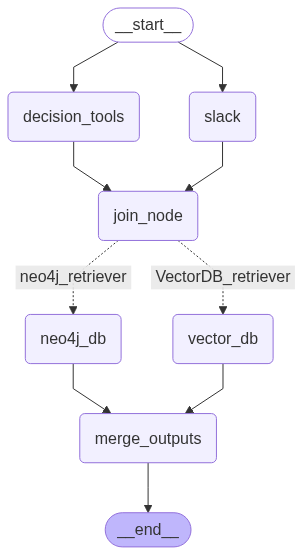

In [ ]:
builder = StateGraph(ChatbotState)

builder.add_node("slack", decision_slack)
builder.add_node("decision_tools", decision_tools)
builder.add_node("join_node", join_node)
builder.add_node("vector_db", vector_db)
builder.add_node("neo4j_db", neo4j_db)
builder.add_node("merge_outputs", merge_outputs)

builder.add_edge(START, "decision_tools")
builder.add_edge(START, "slack")

builder.add_edge("slack", "join_node")
builder.add_edge("decision_tools", "join_node")

def route_tools(state: ChatbotState):
    return state["tools"]

# builder.add_conditional_edges(
#     "decision_tools",
#     route_tools,
#     {
#         "neo4j_retriever": "neo4j_db",
#         "VectorDB_retriever": "vector_db"
#     }
# )

builder.add_conditional_edges(
    "join_node",
    route_tools,
    {
        "neo4j_retriever": "neo4j_db",
        "VectorDB_retriever": "vector_db"
    }
)

builder.add_edge("neo4j_db", "merge_outputs")
builder.add_edge("vector_db", "merge_outputs")
builder.add_edge("merge_outputs", END)

builder.compile(checkpointer=memory)

In [ ]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(configurable={"thread_id": 1})

question = "Kasabach-Merritt Syndrome에 대해 조사해서 백지연에게 Slack으로 보내줘."

graph = builder.compile(checkpointer=memory)

initial_state = {
    "question": question,
    "decision_slack":"",
    "tools": [],
    "tools_query" : [],
    "neo4j_documents": [],
    "vector_documents": [],
    "final_answer": "",
    "slack_response":"",
    "messages": [],
}

events = []
async for event in graph.astream(initial_state, config=config):
    print(event)

{'decision_tools': {'tools': ['VectorDB_retriever', 'neo4j_retriever'], 'tools_query': ['Kasabach-Merritt Syndrome의 정의, 원인, 증상, 진단, 치료에 대한 일반적인 의학 지식 설명', 'Kasabach-Merritt Syndrome과 관련된 환자 사례 또는 Kasabach-Merritt Syndrome을 진단받았거나 이와 유사한 증상을 보인 백지연 포함 환자들의 임상 기록을 요약해줘.']}}
{'slack': {'decision_slack': 'Yes'}}
{'join_node': {'question': 'Kasabach-Merritt Syndrome에 대해 조사해서 백지연에게 Slack으로 보내줘.', 'decision_slack': 'Yes', 'tools': ['VectorDB_retriever', 'neo4j_retriever'], 'tools_query': ['Kasabach-Merritt Syndrome의 정의, 원인, 증상, 진단, 치료에 대한 일반적인 의학 지식 설명', 'Kasabach-Merritt Syndrome과 관련된 환자 사례 또는 Kasabach-Merritt Syndrome을 진단받았거나 이와 유사한 증상을 보인 백지연 포함 환자들의 임상 기록을 요약해줘.'], 'neo4j_documents': [], 'vector_documents': [], 'final_answer': '', 'slack_response': '', 'messages': []}}


ToolException: Error executing tool neo4j_retriever: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'Kasabach': expected 'ALTER', 'ORDER BY', 'CALL', 'USING PERIODIC COMMIT', 'CREATE', 'LOAD CSV', 'START DATABASE', 'STOP DATABASE', 'DEALLOCATE', 'DELETE', 'DENY', 'DETACH', 'DROP', 'DRYRUN', 'FINISH', 'FOREACH', 'GRANT', 'INSERT', 'LIMIT', 'MATCH', 'MERGE', 'NODETACH', 'OFFSET', 'OPTIONAL', 'REALLOCATE', 'REMOVE', 'RENAME', 'RETURN', 'REVOKE', 'ENABLE SERVER', 'SET', 'SHOW', 'SKIP', 'TERMINATE', 'UNWIND', 'USE' or 'WITH' (line 1, column 1 (offset: 0))
"Kasabach-Merritt Syndrome과 관련된 환자 사례 또는 Kasabach-Merritt Syndrome을 진단받았거나 이와 유사한 증상을 보인 백지연 포함 환자들의 임상 기록을 요약해줘."
 ^}